In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
RAD=180/math.pi
eps=1e-4

In [2]:
img=plt.imread('.//Prog1_images//p1im2.bmp')
img=img/255.
print(img.shape)
img[:5,:5,0]

(240, 320, 3)


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

# HSI

### RGB to HSI
![to HSI](http://answers.opencv.org/upfiles/14323328241041215.png)  

In [3]:
def rgb2hsi(image):
    '''
    input shape:  (H,W,C=3)
    output shape: (H,W,HSI=3)
    output range  H=[0,1],S=[0,1],I=[0,1]
    '''
    image_hsi=np.zeros(image.shape)
    for h in range(image.shape[0]):
        for w in range(image.shape[1]):
            R,G,B=image[h,w,:]
            H=math.acos((1/2)*(R-G+R-B)/(math.sqrt((R-G)**2+(R-B)*(G-B))+eps))*RAD
            if B>G:
                H=360-H
            S=1-3/(R+G+B)*min(min(R,G),B)
            I=(1/3)*(R+G+B)
            image_hsi[h,w,:]=[H,S,I]
    image_hsi[:,:,0]/=360
    return image_hsi                

### HSI to RGB

In [4]:
def hsi2rgb(image):
    image_rgb=np.zeros(image.shape)
    for h in range(image.shape[0]):
        for w in range(image.shape[1]):
            H,S,I=image[h,w,:]
            H*=360
            x=I*(1-S)
            y=I*(1+S*math.cos(H%120/RAD)/math.cos((60-H%120)/RAD))
            z=3*I-(x+y)
            if H<=120:
                R=y
                G=z
                B=x
            elif H<=240:
                R=x
                G=y
                B=z
            else:
                R=z
                G=x
                B=y
            #clip range into [0,1]
            R=min(max(0,R),1) 
            G=min(max(0,G),1)
            B=min(max(0,B),1)
            image_rgb[h,w,:]=[R,G,B]
    
    return image_rgb

# HSV

### RGB to HSV

In [5]:
def rgb2hsv(image):
    '''
    output shape:  (H,W,HSV=3)
    output range:  H=[0,360],S=[0,1],V=[0,1]
    '''
    image_hsv=np.zeros(image.shape)
    for h in range(image.shape[0]):
        for w in range(image.shape[1]):
            R,G,B=image[h,w,:]
            MIN=min(min(R,G),B)
            MAX=max(max(R,G),B)
            
            V=MAX
            
            if MAX!=0:
                S=(MAX-MIN)/MAX
            else:
                S=0
            
            if MAX==MIN:
                H=0
            elif MAX==R:
                if G>=B:
                    H=60*(G-B)/(MAX-MIN)
                else:
                    H=60*(G-B)/(MAX-MIN)+360
            elif MAX==G:
                H=60*(B-R)/(MAX-MIN)+120
            else:
                H=60*(R-G)/(MAX-MIN)+240
            image_hsv[h,w,:]=[H,S,V]
    return image_hsv

### HSV to RGB

In [6]:
def hsv2rgb(image):
    image_rgb=np.zeros(image.shape)
    for h in range(image.shape[0]):
        for w in range(image.shape[1]):
            H,S,V=image[h,w,:]
            Hi=int(H/60)
            f=H/60-Hi
            p=V*(1-S)
            q=V*(1-f*S)
            t=V*(1-(1-f)*S)
            
            if Hi==0:
                image_rgb[h,w,:]=[V,t,p]
            elif Hi==1:
                image_rgb[h,w,:]=[q,V,p]
            elif Hi==2:
                image_rgb[h,w,:]=[p,V,t]
            elif Hi==3:
                image_rgb[h,w,:]=[p,q,V]
            elif Hi==4:
                image_rgb[h,w,:]=[t,p,V]
            elif Hi==5:
                image_rgb[h,w,:]=[V,p,q]
    return image_rgb

# color image: dark to light

In [72]:
def intensity_transform_hsi(image,gamma,s):
    '''
    gamma:  gamma transform on I
    s:      a small offset of S
    '''
    image_hsi=rgb2hsi(image)
    
    image_hsi[:,:,2]=image_hsi[:,:,2]**gamma
    image_hsi[:,:,1]=image_hsi[:,:,1]+s
    
    result=hsi2rgb(image_hsi)
    titles=['original image','result with gamma={:.1f}, s={:.1f}'.format(gamma,s)]
    images=[image,result]
    plt.figure(figsize=(15,15))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    return image

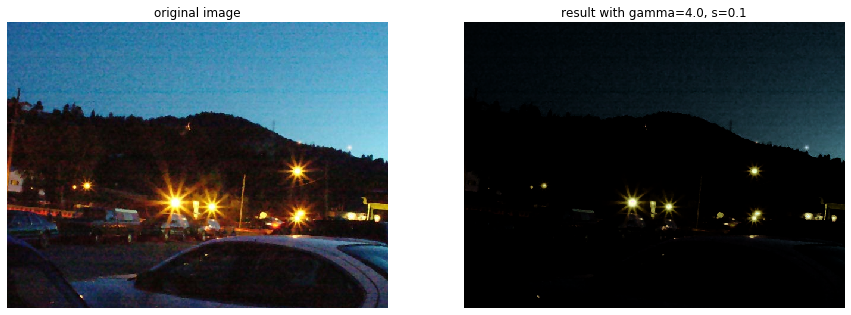

In [74]:
intensity_transform_hsi(img,4,0.1);

In [9]:
def intensity_transform_hsv(image,h,s,v):
    '''
    h:  offset of H
    s:  offset of S
    v:  offset pf V
    h range:  [-360,360]
    s range:  [-1,1]
    v range:  [-1,1]
    '''
    image_hsv=rgb2hsv(image)
    image_hsv[:,:,0]=(image_hsv[:,:,0]+h)%360
    image_hsv[:,:,1]=image_hsv[:,:,1]+s
    image_hsv[:,:,2]=image_hsv[:,:,2]+v
    result=hsv2rgb(image_hsv)
    result-=np.min(result)
    result/=np.max(result)
    titles=['original image','result with h={:.1f}, s={:.1f}, v={:.1f}'.format(h,s,v)]
    images=[image,result]
    plt.figure(figsize=(15,15))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')

# 2DConv

In [13]:
def cross_correlation(m1,m2):
        return np.sum(m1*m2)

In [14]:
def conv2D(image,kernel):
    H,W,C=image.shape
    fh,fw=kernel.shape
    image_pad=np.pad(image,((fh//2,fh//2),((fw//2,fw//2)),(0,0)),'symmetric')
    #print('image shape:',image.shape,' image_padding shape:',image_pad.shape)
    res=np.zeros(image.shape,float)
    for i in range(H):
        for j in range(W):
            for c in range(C):
                res[i,j,c]=cross_correlation(image_pad[i:i+fh,j:j+fw,c],kernel)
    return res

# test

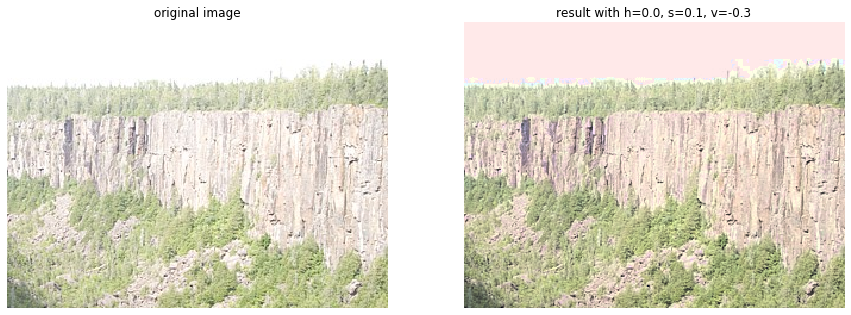

In [61]:
img=plt.imread('.//Prog1_images//p1im2.bmp')
img=img/255.
intensity_transform_hsv(img,0,0.1,-0.3)

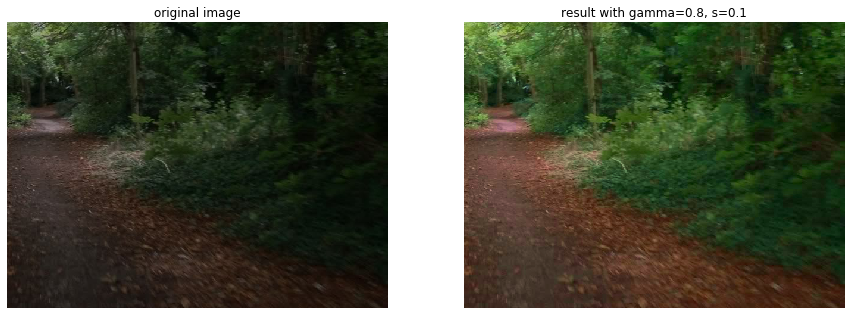

In [11]:
img=plt.imread('.//Prog1_images//p1im1.bmp')
img=img/255.
intensity_transform_hsi(img,0.75,0.1)

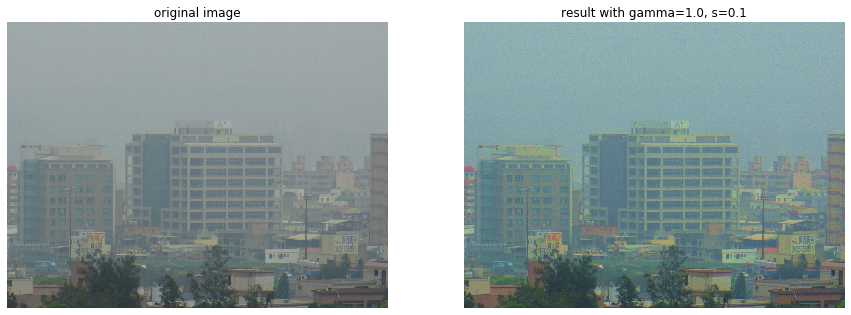

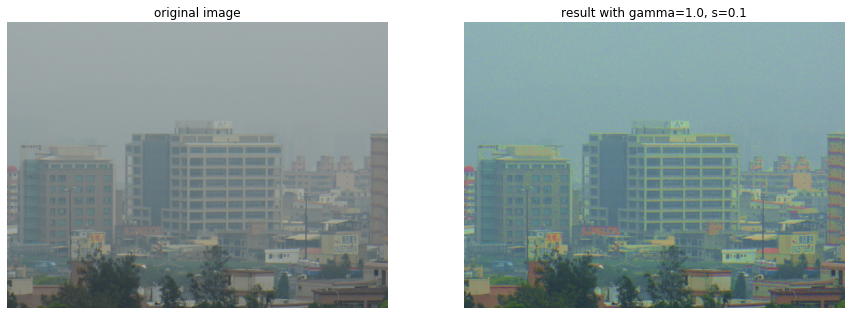

In [23]:
img=plt.imread('.//Prog1_images//p1im5.bmp')
img=img/255.
intensity_transform_hsi(img,1,0.1)

size=3
kernel=np.ones((size,size))/(size**2)
result=conv2D(img,kernel)
intensity_transform_hsi(result,1,0.1)

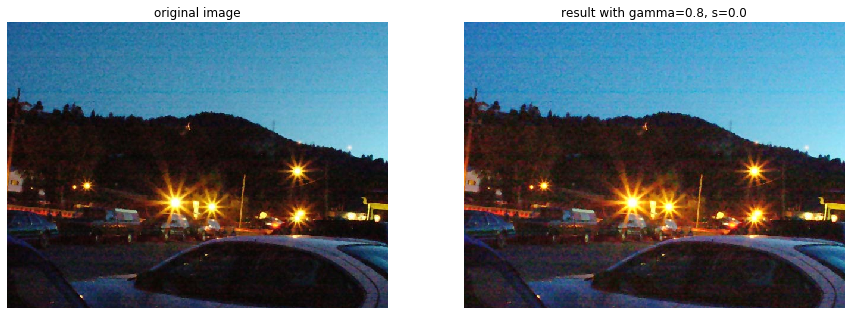

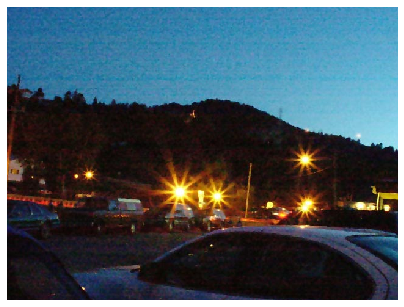

In [75]:
img=plt.imread('.//Prog1_images//p1im3.bmp')
img=img/255.
img=intensity_transform_hsi(img,0.8,0);

kernel=np.ones((size,size))/(size**2)
result=conv2D(img,kernel)
plt.figure(figsize=(7,9))
plt.axis('off')
plt.imshow(img)
plt.show()

# Bilateral

In [107]:
image=plt.imread('.//Prog1_images//p1im6.bmp')
size=5

In [108]:
def closeness(H,W,sigma):
    r,c=np.mgrid[0:H:1,0:W:1]
    r-=H//2
    c-=W//2
    res=np.exp(-(np.power(r,2)+np.power(c,2))/(2*sigma*sigma))
    return res

In [109]:
def similarity(section,sigma):
    H,W=section.shape
    center_intensity=section[H//2,W//2]
    res=np.exp(-np.power(section-center_intensity,2)/(2*sigma*sigma))
    return res

In [110]:
sigma_c=10  #sigma for closeness
sigma_s=0.1 #sigma for similarity

In [111]:
closeness_filter=closeness(size,size,sigma_c)

image_pad=np.pad(image/255,((size//2,size//2),(size//2,size//2),(0,0)),'symmetric')
blur=np.zeros(image.shape,float)
H,W,C=blur.shape
for i in range(H):
    for j in range(W):
        for c in range(C):
            closeness_similarity_filter=closeness_filter*similarity(image_pad[i:i+size,j:j+size,c],sigma_s)
            #normalized
            closeness_similarity_filter=closeness_similarity_filter/np.sum(closeness_similarity_filter)
            blur[i,j,c]=cross_correlation(image_pad[i:i+size,j:j+size,c],closeness_similarity_filter)

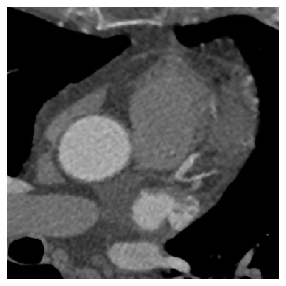

In [112]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(blur) #because of image/255,so don't have to add .astype(int)
plt.show()

In [113]:
def bilateral(sigma_c,sigma_s):
    closeness_filter=closeness(size,size,sigma_c)

    image_pad=np.pad(image/255,((size//2,size//2),(size//2,size//2),(0,0)),'symmetric')
    blur=np.zeros(image.shape,float)
    H,W,C=blur.shape
    for i in range(H):
        for j in range(W):
            for c in range(C):
                closeness_similarity_filter=closeness_filter*similarity(image_pad[i:i+size,j:j+size,c],sigma_s)
                #normalized
                closeness_similarity_filter=closeness_similarity_filter/np.sum(closeness_similarity_filter)
                blur[i,j,c]=cross_correlation(image_pad[i:i+size,j:j+size,c],closeness_similarity_filter)
    return blur

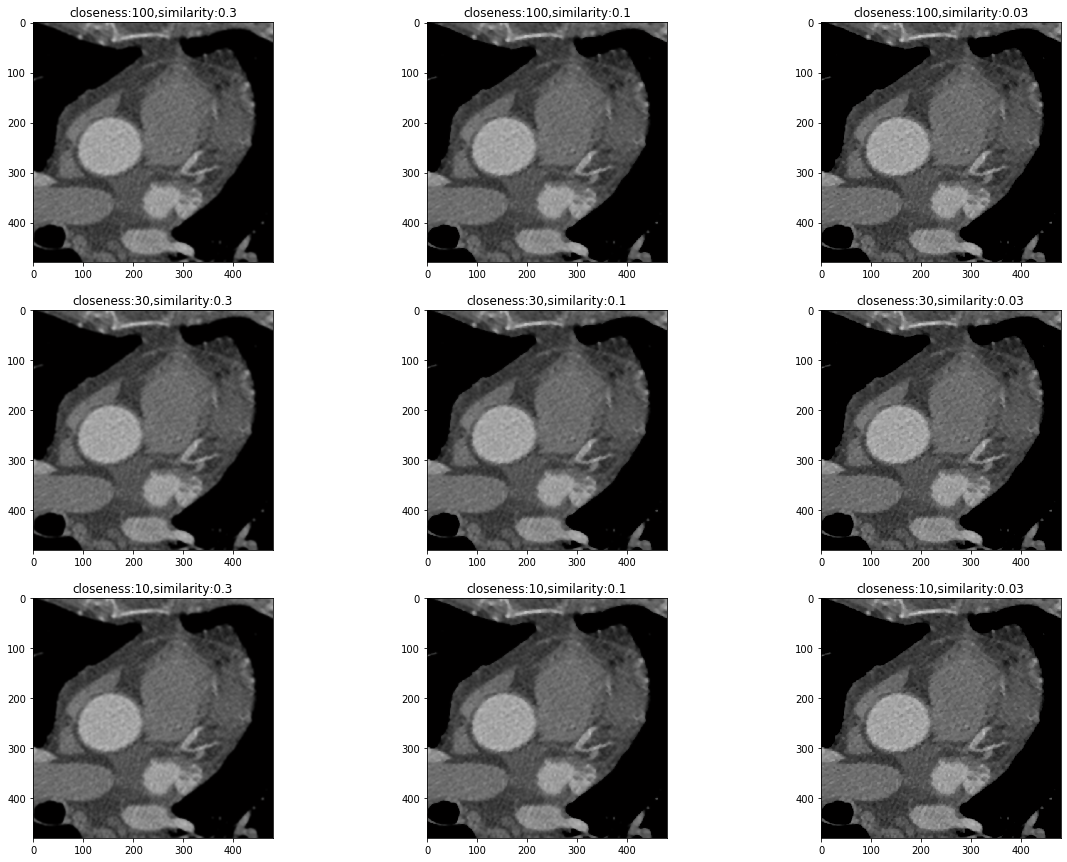

In [114]:
#watch out,this cell takes about 4 minutes to execute
sigma_c_list=[100,30,10] #big->small
sigma_s_list=[0.3,0.1,0.03] #big->small

plt.figure(figsize=(20,15))
i=1
for sigma_c in sigma_c_list:
    for sigma_s in sigma_s_list:
        plt.subplot(3,3,i)
        plt.imshow(bilateral(sigma_c,sigma_s))
        plt.title('closeness:{},similarity:{}'.format(sigma_c,sigma_s))
        i+=1

# Blur

In [62]:
size=5

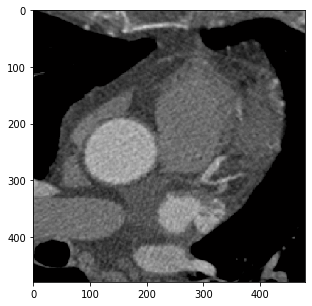

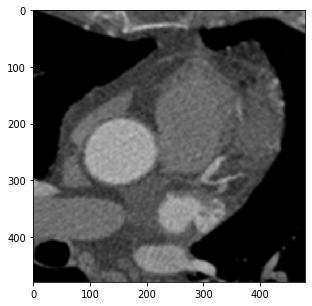

In [63]:
img=plt.imread('.//Prog1_images//p1im6.bmp')
img=img/255.
kernel=np.ones((size,size))/(size**2)
result=conv2D(img,kernel)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(result)
plt.show()

# Laplacian Sharpen

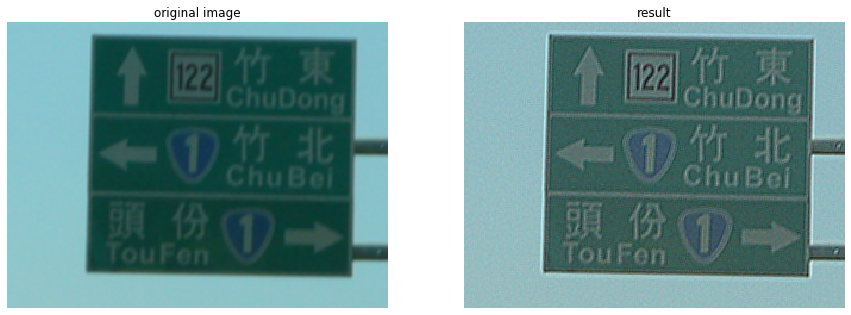

In [91]:
img=plt.imread('.//Prog1_images//p1im4.bmp')
img=img/255.

img=conv2D(img,np.ones((3,3))/9)
kernel=np.asarray([[0,-1,0],[-1,4,-1],[0,-1,0]])
result=conv2D(img,kernel)
result-=np.min(result)
result/=np.max(result)
result=img+result
result-=np.min(result)
result/=np.max(result)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('result')
plt.imshow(result)
plt.show()

In [92]:
np.max(result)

1.0

# <font color='#ff0000'>test</font>

In [ ]:
plt.imshow(img)

In [ ]:
img_=rgb2hsv(img)
recover=hsv2rgb(img_)
plt.imshow(recover)

In [ ]:
print(img[0,0,:])
print(img_hsi[100,100,:])
print(recover[0,0,:])